In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
if False:
    !mkdir "/content/drive/My Drive/tf_od_demo"
%cd "/content/drive/My Drive/tf_od_demo"

/content/drive/My Drive/tf_od_demo


In [3]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [4]:
!pip install tf_slim

     |████████████████████████████████| 358kB 2.8MB/s 


In [5]:
!pip install object_detection

     |████████████████████████████████| 1.5MB 2.8MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=7398a44b2ebcad2845694ab7b4e9897b7d04ae166c725ae1e555d569a5f0ab2a
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3


In [129]:
import numpy as np
from matplotlib import pyplot as plt
import imageio

import tensorflow as tf

import sys
sys.path.insert(0, 'models/research')

from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [128]:
def class_text_to_int(row_label):
  if row_label == 'train':
    return 1
  elif row_label == 'dog':
    return 2
  else:
    None

In [36]:
def create_tf_example(example):
  
    img_fpath = os.path.join('data_two', example.id)
    img = Image.open(img_fpath)
    height = img.size[1]
    width = img.size[0]
    filename = str.encode(example.id)
    with open(img_fpath, mode='rb') as f:
        encoded_image_data = f.read()
    image_format = b'jpeg'
    classes_text=[]
    classes = []

    # List of normalized left x coordinates in bounding box (1 per box)
    xmins = [example.xmin / float(width)] 
    # List of normalized right x coordinates in bounding box # (1 per box)
    xmaxs = [example.xmax / float(width)] 
    # List of normalized top y coordinates in bounding box (1 per box)
    ymins = [example.ymin / float(height)] 
    # List of normalized bottom y coordinates in bounding box # (1 per box)
    ymaxs = [example.ymax / float(height)] 
    # List of string class name of bounding box (1 per box)
    classes_text.append(row['class'].encode('utf8'))
    classes.append(class_text_to_int(row['class']))


    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_image_data),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example

In [127]:
import pandas as pd
annot = pd.read_csv('data_two/annot_two.csv')
annot.head()

,class,id,xmin,ymin,xmax,ymax
0,train,IMG_7765.jpg,425,100,610,355
1,dog,IMG_7765.jpg,42,87,200,340
2,train,IMG_7766.jpg,405,121,595,370
3,dog,IMG_7766.jpg,40,135,200,368
4,train,IMG_7767.jpg,415,118,600,361


In [126]:
import os
from PIL import Image
from object_detection.utils import dataset_util
writer = tf.python_io.TFRecordWriter('data_two/train_data.record')

for idx, row in annot.iterrows():
    tf_example = create_tf_example(row)
    writer.write(tf_example.SerializeToString())

writer.close()

In [152]:
%%time

if False:
    # Delete output directory
    !rm -rf data_two//output

!export PYTHONPATH=$PYTHONPATH:models/research:models/research/slim ; python models/research/object_detection/model_main.py \
    --pipeline_config_path=data_two/pipeline.config \
    --model_dir=data_two/output \
    --num_train_steps=20000 \
    --alsologtostderr

W0721 10:57:32.722557 140179711051648 model_lib.py:758] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting train_steps: 20000
I0721 10:57:32.722809 140179711051648 config_util.py:552] Maybe overwriting train_steps: 20000
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0721 10:57:32.722966 140179711051648 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: 1
I0721 10:57:32.723114 140179711051648 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: 1
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0721 10:57:32.723259 140179711051648 config_util.py:552] Maybe overwriting eval_num_epochs: 1
W0721 10:57:32.723456 140179711051648 model_lib.py:774] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
INFO:tensorflow:create_estimator_and_inputs: use_tpu False, export_to

In [153]:
!export PYTHONPATH=$PYTHONPATH:models/research:models/research/slim ; python models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path=data_two/pipeline.config \
    --trained_checkpoint_prefix=data_two/output/model.ckpt-20000\
    --output_directory=data_two/output/frozen/!export PYTHONPATH=$PYTHONPATH:models/research:models/research/slim ; python models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path=data_two/pipeline.config \
    --trained_checkpoint_prefix=data_two/output/model.ckpt-20000\
    --output_directory=data_two/output/frozen/

Instructions for updating:
Please use `layer.__call__` method instead.
W0721 11:29:17.619816 140412035479424 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tf_slim/layers/layers.py:1089: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0721 11:29:19.451008 140412035479424 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0721 11:29:19.498862 140412035479424 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0721 11:29:19.550517 140412035479424 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv befo

In [154]:
PATH_TO_LABELS = 'data_two/label_map.pbtxt'

category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [155]:
PATH_TO_FROZEN_GRAPH = 'data_two/output/frozen/frozen_inference_graph.pb'

detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

In [156]:
def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[1], image.shape[2])
                detection_masks_reframed = tf.cast(tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict, feed_dict={image_tensor: image})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[ 'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

In [158]:
image_np = imageio.imread('data_two/test.jpg')
image_np_expanded = np.expand_dims(image_np, axis=0)

output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)

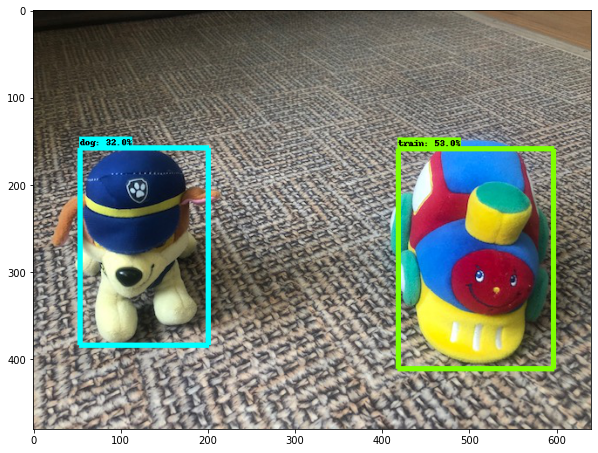

In [160]:
vis_util.visualize_boxes_and_labels_on_image_array(
    image_np,
    output_dict['detection_boxes'],
    output_dict['detection_classes'],
    output_dict['detection_scores'],
    category_index,
    instance_masks=output_dict.get('detection_masks'),
    use_normalized_coordinates=True,
    line_thickness=6,
    min_score_thresh=0.3)

%matplotlib inline
plt.figure(figsize=(10,10))
plt.imshow(image_np)